In [6]:
### Dependencies
import pandas as pd
from pathlib import Path
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping


In [3]:
### Data Loading

def load_csv(file_name: str) -> pd.DataFrame:
    """
    Load a CSV file from the data directory.
    """
    data_path = Path.cwd().parent / "data" / file_name 
    if not data_path.exists():
        raise FileNotFoundError(f"{data_path} not found.")

    df = pd.read_csv(data_path, parse_dates=['Date'])
    
    # Parse 'Date' column explicitly
    # MM/DD/YY format
    df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%y', errors='coerce')
    
    # Correct future years (pandas may interpret '30' as 2030)
    # Assume dates from 1928–2020
    df.loc[df['Date'] > pd.Timestamp.today(), 'Date'] -= pd.offsets.DateOffset(years=100)
    
    # Sort by date
    df = df.sort_values('Date').reset_index(drop=True)
    return df 



def add_features(df: pd.DataFrame, rolling_window: int = 10):
    """
    Add features for ML: returns, rolling volatility, price/volume features, lags.
    Handles NaN and infinite values, ready for scaling.
    """
    df = df.copy()
    
    # Returns and volatility
    df['Return'] = df['Adj Close'].pct_change()
    df['Volatility'] = df['Return'].rolling(rolling_window).std()

    # Price-based features
    df['High_Low_pct'] = (df['High'] - df['Low']) / df['Close']
    df['Close_Open_pct'] = (df['Close'] - df['Open']) / df['Open']
    df['MA5'] = df['Close'].rolling(5).mean()
    df['MA10'] = df['Close'].rolling(10).mean()

    # Volume-based features
    df['Volume_pct_change'] = df['Volume'].pct_change()
    df['Volume_MA5'] = df['Volume'].rolling(5).mean()

    # Lag features
    df['Return_lag1'] = df['Return'].shift(1)
    df['Return_lag2'] = df['Return'].shift(2)
    df['Volatility_lag1'] = df['Volatility'].shift(1)

    # Target: 10 days-ahead volatility
    df['Volatility_future'] = df['Volatility'].shift(-10)

    # Replace inf with NaN
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Fill volume-related NaNs (common in early data)
    df['Volume_pct_change'] = df['Volume_pct_change'].fillna(0)
    df['Volume_MA5'] = df['Volume_MA5'].ffill()

    # Drop only rows where the key features are missing
    df = df[df['Volatility'].notna() & df['Volatility_future'].notna()]
    df.reset_index(drop=True, inplace=True)

    # Features to scale
    features = [
        'Return', 'High_Low_pct', 'Close_Open_pct', 'MA5', 'MA10',
        'Volume_pct_change', 'Volume_MA5', 'Return_lag1', 'Return_lag2', 'Volatility_lag1'
    ]

    # Scaling
    scaler = StandardScaler()
    df[features] = scaler.fit_transform(df[features].values)

    target_col = 'Volatility_future'
    return df, features, target_col


# Load raw data
df = load_csv("SPX.csv")

# Preprocess
df_prepared, feature_cols, target_col = add_features(df)

X = df_prepared[feature_cols]
y = df_prepared[target_col]

# Drop any row where X or y has NaN
mask = (~X.isna().any(axis=1)) & (~y.isna())
X = X[mask]
y = y[mask]

print(X.head(), y.head())


# Split data into train (80%) and test (20%) by time
split_idx = int(len(df_prepared) * 0.8)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

/tmp/ipykernel_31655/3369933274.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(data_path, parse_dates=['Date'])


     Return  High_Low_pct  Close_Open_pct       MA5      MA10  \
1  0.023311      -0.92304       -0.023226 -0.647124 -0.647122   
2 -0.217569      -0.92304       -0.023226 -0.647148 -0.647185   
3  0.554534      -0.92304       -0.023226 -0.647173 -0.647209   
4  0.454640      -0.92304       -0.023226 -0.647201 -0.647234   
5  0.737950      -0.92304       -0.023226 -0.647104 -0.647214   

   Volume_pct_change  Volume_MA5  Return_lag1  Return_lag2  Volatility_lag1  
1          -0.060194   -0.522899    -1.399673     0.499832        -0.166255  
2          -0.060194   -0.522899     0.023281    -1.399676        -0.217933  
3          -0.060194   -0.522899    -0.217598     0.023273        -0.217969  
4          -0.060194   -0.522899     0.554501    -0.217605        -0.203854  
5          -0.060194   -0.522899     0.454607     0.554491        -0.210628   1    0.007275
2    0.007273
3    0.007181
4    0.008303
5    0.007715
Name: Volatility_future, dtype: float64
Train size: 18642, Test size: 4

In [15]:
# Train NN LSTM (Cameron)

model = Sequential([
    LSTM(50, input_shape=(X_train.shape[1], 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train.values.reshape(-1, X_train.shape[1], 1), y_train.values, epochs=50, batch_size=32)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Mean Squared Error: {mse:.6f}")
print(f"Accuracy (R2): {r2 * 100:.2f}%")

# First predictions
print("-------------------")
print("Sample predictions:")
print(y_pred[:5])

Epoch 1/50


2025-11-02 08:19:25.021029: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/cameron/miniconda3/envs/mlenv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6.5239e-05  
Epoch 2/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 987us/step - loss: 3.5762e-05
Epoch 3/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 1000us/step - loss: 3.5882e-05
Epoch 4/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 994us/step - loss: 3.6416e-05
Epoch 5/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 992us/step - loss: 3.2328e-05
Epoch 6/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 990us/step - loss: 3.3380e-05
Epoch 7/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 975us/step - loss: 3.2826e-05
Epoch 8/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 978us/step - loss: 3.2779e-05
Epoch 9/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 995us/step - loss: 3.1548e-05
Epoch 10/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.0751e-05  
Epoch 11/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 991us/step - loss: 3.1899e-05
Epoch 12/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 983us/step - loss: 3.0880e-05
Epoch 13/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 998us/step - loss: 3.0498e-05
Epoch 14/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 993us/step - 

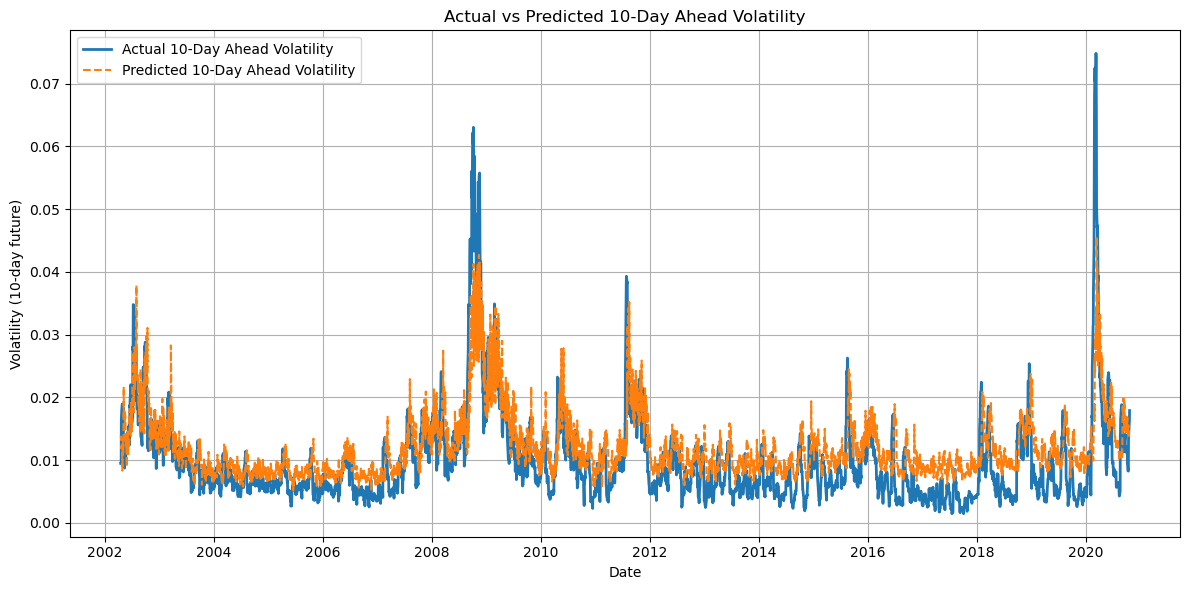

In [19]:
# Plotting



# Plot actual vs predicted volatility on the test set
plt.figure(figsize=(12, 6))
plt.plot(df_prepared['Date'].iloc[split_idx:-1], y_test, label='Actual 10-Day Ahead Volatility', linewidth=2)
plt.plot(df_prepared['Date'].iloc[split_idx:-1], y_pred, label='Predicted 10-Day Ahead Volatility', linestyle='--')

plt.title('Actual vs Predicted 10-Day Ahead Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility (10-day future)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


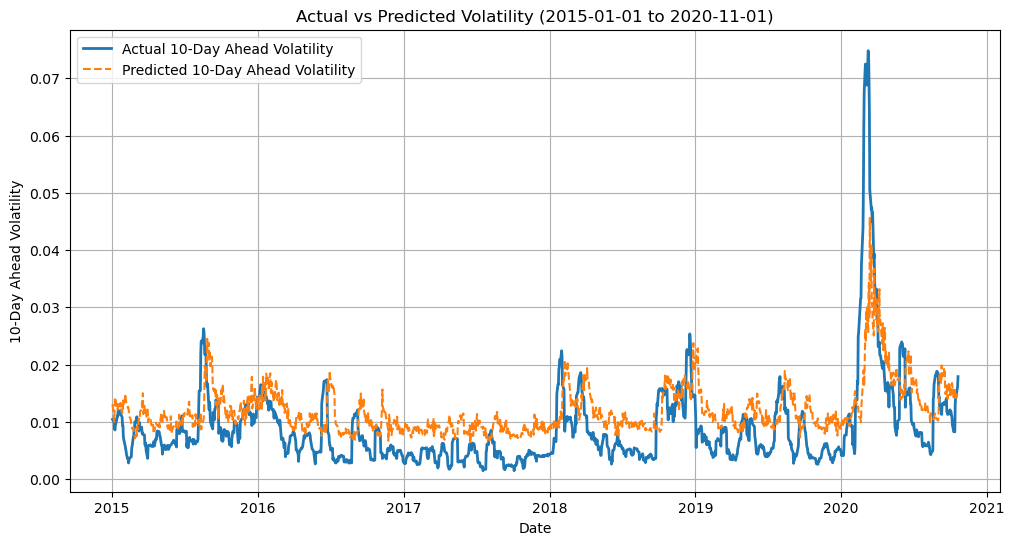

In [20]:
## Zoom in to see data better

# Combine dates, actual, and predicted into a single DataFrame
plot_df = df_prepared.iloc[split_idx:split_idx+len(y_test)].copy()
plot_df['Actual'] = y_test.values
plot_df['Predicted'] = y_pred
plot_df.set_index('Date', inplace=True)  # Set Date as index for easy slicing

# Define the zoom window
window_start = '2015-01-01'
window_end = '2020-11-01'

# Slice the DataFrame to the desired time window
subset = plot_df.loc[window_start:window_end]

# Plot
plt.figure(figsize=(12,6))
plt.plot(subset.index, subset['Actual'], label='Actual 10-Day Ahead Volatility', linewidth=2)
plt.plot(subset.index, subset['Predicted'], label='Predicted 10-Day Ahead Volatility', linestyle='--')
plt.title(f'Actual vs Predicted Volatility ({window_start} to {window_end})')
plt.xlabel('Date')
plt.ylabel('10-Day Ahead Volatility')
plt.legend()
plt.grid(True)
plt.show()

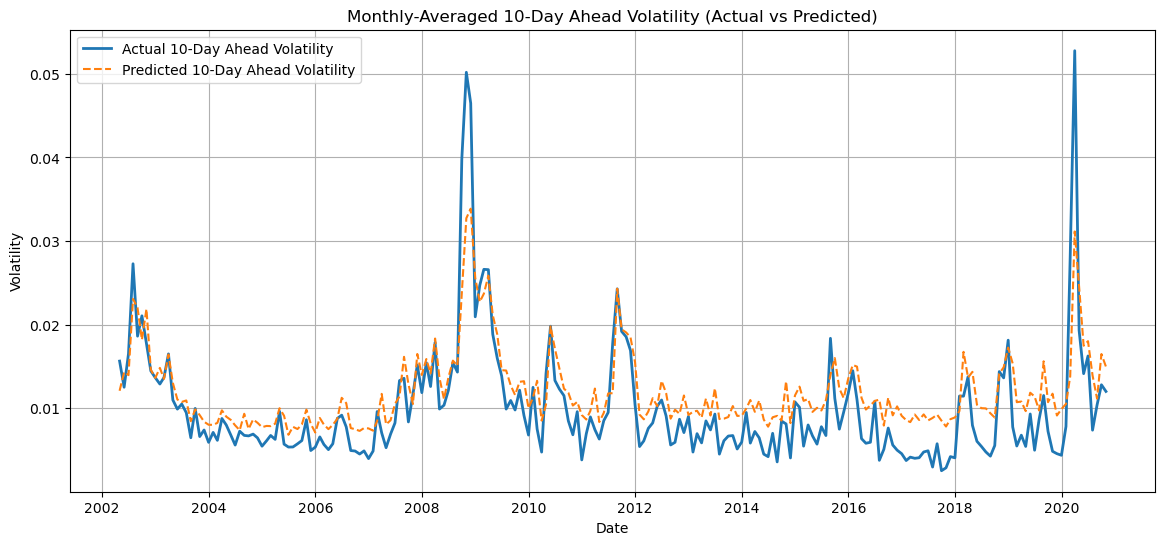

In [21]:
# Combine dates, actual, and predicted into one dataframe
plot_df = df_prepared.iloc[split_idx:split_idx+len(y_test)].copy()
plot_df['Actual'] = y_test.values
plot_df['Predicted'] = y_pred

# Resample monthly
plot_df.set_index('Date', inplace=True)
plot_monthly = plot_df.resample('ME').mean()

plt.figure(figsize=(14,6))
plt.plot(plot_monthly.index, plot_monthly['Actual'], label='Actual 10-Day Ahead Volatility', linewidth=2)
plt.plot(plot_monthly.index, plot_monthly['Predicted'], label='Predicted 10-Day Ahead Volatility', linestyle='--')
plt.title('Monthly-Averaged 10-Day Ahead Volatility (Actual vs Predicted)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# Define the model building function for hyperparameter tuning
def build_model(hp):
    model = Sequential()
    
    # Tune number of LSTM units
    units = hp.Int('units', min_value=32, max_value=256, step=32)
    
    # Tune dropout rate
    dropout = hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)
    
    # First LSTM layer
    model.add(LSTM(
        units=units,
        input_shape=(X_train.shape[1], 1),
        dropout=dropout,
        return_sequences=hp.Boolean('return_sequences')
    ))
    
    # Optionally add a second LSTM layer
    if hp.Boolean('add_second_layer'):
        units_2 = hp.Int('units_2', min_value=16, max_value=128, step=16)
        model.add(LSTM(units=units_2, dropout=dropout))
    
    # Optionally add dense layer before output
    if hp.Boolean('add_dense_layer'):
        dense_units = hp.Int('dense_units', min_value=16, max_value=64, step=16)
        model.add(Dense(dense_units, activation='relu'))
        model.add(Dropout(dropout))
    
    # Output layer
    model.add(Dense(1))
    
    # Tune learning rate
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae']
    )
    
    return model

# Create the tuner (using Hyperband algorithm)
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=50,
    factor=3,
    directory='lstm_tuning',
    project_name='hyperparameter_search',
    overwrite=True
)

# Print search space summary
print("Search Space Summary:")
print(tuner.search_space_summary())

# Prepare data
X_train_reshaped = X_train.values.reshape(-1, X_train.shape[1], 1)
X_test_reshaped = X_test.values.reshape(-1, X_test.shape[1], 1)

# Early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Run the hyperparameter search
print("\nStarting hyperparameter search...")
tuner.search(
    X_train_reshaped, 
    y_train.values,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_reshaped, y_test.values),
    callbacks=[early_stop],
    verbose=1
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\n" + "="*60)
print("BEST HYPERPARAMETERS FOUND:")
print("="*60)
print(f"LSTM Units: {best_hps.get('units')}")
print(f"Dropout Rate: {best_hps.get('dropout'):.2f}")
print(f"Learning Rate: {best_hps.get('learning_rate'):.6f}")
print(f"Return Sequences: {best_hps.get('return_sequences')}")
print(f"Add Second LSTM Layer: {best_hps.get('add_second_layer')}")
if best_hps.get('add_second_layer'):
    print(f"  Second Layer Units: {best_hps.get('units_2')}")
print(f"Add Dense Layer: {best_hps.get('add_dense_layer')}")
if best_hps.get('add_dense_layer'):
    print(f"  Dense Layer Units: {best_hps.get('dense_units')}")
print("="*60)

# Build and train the best model
print("\nTraining the best model...")
best_model = tuner.hypermodel.build(best_hps)

history = best_model.fit(
    X_train_reshaped,
    y_train.values,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_reshaped, y_test.values),
    callbacks=[early_stop],
    verbose=1
)

# Predict on the test set
y_pred = best_model.predict(X_test_reshaped)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print results
print("\n" + "="*60)
print("FINAL MODEL PERFORMANCE:")
print("="*60)
print(f"Mean Squared Error: {mse:.6f}")
print(f"R² Score: {r2:.6f}")
print(f"Accuracy (R²): {r2 * 100:.2f}%")
print("="*60)

# Compare with original model
print("\n" + "="*60)
print("COMPARISON WITH ORIGINAL MODEL:")
print("="*60)

# Train original model for comparison
original_model = Sequential([
    LSTM(50, input_shape=(X_train.shape[1], 1)),
    Dense(1)
])
original_model.compile(optimizer='adam', loss='mse')
original_model.fit(
    X_train_reshaped, 
    y_train.values, 
    epochs=50, 
    batch_size=32, 
    verbose=0
)

y_pred_original = original_model.predict(X_test_reshaped)
mse_original = mean_squared_error(y_test, y_pred_original)
r2_original = r2_score(y_test, y_pred_original)

print(f"Original Model - MSE: {mse_original:.6f}, R²: {r2_original * 100:.2f}%")
print(f"Tuned Model    - MSE: {mse:.6f}, R²: {r2 * 100:.2f}%")
print(f"Improvement    - MSE: {((mse_original - mse) / mse_original * 100):.2f}%")
print(f"Improvement    - R²: {((r2 - r2_original) / abs(r2_original) * 100):.2f}%")
print("="*60)

# Save the best model
best_model.save('best_lstm_model.h5')
print("\nBest model saved as 'best_lstm_model.h5'")

# Show top 3 models
print("\n" + "="*60)
print("TOP 3 MODELS:")
print("="*60)
for i, hps in enumerate(tuner.get_best_hyperparameters(num_trials=3), 1):
    print(f"\nModel {i}:")
    print(f"  Units: {hps.get('units')}, Dropout: {hps.get('dropout'):.2f}")
    print(f"  Learning Rate: {hps.get('learning_rate'):.6f}")
    print(f"  Second Layer: {hps.get('add_second_layer')}")

Trial 68 Complete [00h 00m 15s]
val_loss: 5.5890406656544656e-05

Best val_loss So Far: 2.37493404711131e-05
Total elapsed time: 00h 09m 26s

BEST HYPERPARAMETERS FOUND:
LSTM Units: 64
Dropout Rate: 0.00
Learning Rate: 0.007510
Return Sequences: True
Add Second LSTM Layer: True
  Second Layer Units: 64
Add Dense Layer: False

Training the best model...
Epoch 1/50
583/583 [==============================] - 3s 3ms/step - loss: 1.6529e-04 - mae: 0.0047 - val_loss: 2.9762e-05 - val_mae: 0.0040
Epoch 2/50
583/583 [==============================] - 2s 3ms/step - loss: 3.0723e-05 - mae: 0.0034 - val_loss: 2.9984e-05 - val_mae: 0.0035
Epoch 3/50
583/583 [==============================] - 2s 3ms/step - loss: 2.9687e-05 - mae: 0.0034 - val_loss: 3.1422e-05 - val_mae: 0.0039
Epoch 4/50
583/583 [==============================] - 2s 3ms/step - loss: 2.9947e-05 - mae: 0.0034 - val_loss: 3.4514e-05 - val_mae: 0.0037
Epoch 5/50
583/583 [==============================] - 2s 3ms/step - loss: 2.9572e-05 

/home/cameron/miniconda3/envs/ml/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
